In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from collections import Counter
import requests
import random
import math
import json
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [31]:
#Download tree json
# tree_url = "https://data.nextstrain.org/ncov_gisaid_global.json"
tree_url = "https://data.nextstrain.org/ncov_global_2021-05-19.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [3]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [4]:
def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list

In [5]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [6]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [7]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()

                    if str(codon_ref_aa) == str(codon_mutated_translation):
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [8]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [32]:
add_syn_mut_attribute(tree)

In [33]:
for node in tree.find_clades(terminal=False):

    node.s1_nonsyn_at_node = 0
    node.s1_syn_at_node = 0
    node.rdrp_nonsyn_at_node = 0

    if hasattr(node, "node_attrs") and 'S1' in node.node_attrs['syn_muts']:
        node.s1_syn_at_node = len(node.node_attrs['syn_muts']['S1'])


    if hasattr(node, 'branch_attrs'):

        s1_nonsyn_at_this_node = []
        if "S" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["S"]:
                if int(mut[1:-1]) in range(14,686):
                    s1_nonsyn_at_this_node.append(mut)

        s1_consolidated = consolidate_deletions(s1_nonsyn_at_this_node)
        node.s1_nonsyn_at_node = len(s1_consolidated)



        rdrp_nonsyn_at_this_node = []
        if "ORF1a" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1a"]:
                if int(mut[1:-1]) in range(4492,4401):
                    rdrp_nonsyn_at_this_node.append(mut)


        if "ORF1b" in node.branch_attrs["mutations"]:
            for mut in node.branch_attrs["mutations"]["ORF1b"]:
                if int(mut[1:-1]) in range(1,923):
                    rdrp_nonsyn_at_this_node.append(mut)

        rdrp_consolidated = consolidate_deletions(rdrp_nonsyn_at_this_node)
        node.rdrp_nonsyn_at_node = len(rdrp_consolidated)


In [34]:
# find number of nodes that have S1 mutations
# consider only internal branches
nodes_with_s1_nonsyn = 0
total_s1_nonsyn = 0
nodes_with_s1_syn = 0
total_s1_syn = 0

for node in tree.find_clades(terminal=False):
    if node.name != 'USA/OR-OSPHL00881/2021':
        if node.s1_nonsyn_at_node!= 0:
            nodes_with_s1_nonsyn+=1
            total_s1_nonsyn += node.s1_nonsyn_at_node
        if node.s1_syn_at_node!=0:
            nodes_with_s1_syn+=1
            total_s1_syn += node.s1_syn_at_node
        
        
print(f'Nodes with S1 nonsyn mutations: {nodes_with_s1_nonsyn}')
print(f'Total number of S1 nonsyn mutations: {total_s1_nonsyn}')
print(f'Nodes with S1 syn mutations: {nodes_with_s1_syn}')
print(f'Total number of S1 syn mutations: {total_s1_syn}')


# find number of nodes that have RdRp mutations
nodes_with_rdrp_muts = 0
total_rdrp_muts = 0

for node in tree.find_clades(terminal=False):
    # exclude this outlier
    if node.name != 'USA/OR-OSPHL00881/2021':
        if node.rdrp_nonsyn_at_node!= 0:
            nodes_with_rdrp_muts+=1
            total_rdrp_muts += node.rdrp_nonsyn_at_node
        
print(f'Nodes with RdRp mutations: {nodes_with_rdrp_muts}')
print(f'Total number of RdRp mutations: {total_rdrp_muts}')

first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades(terminal=False):
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
print(f'Time window: {first_timepoint}-{last_timepoint}')
    

Nodes with S1 nonsyn mutations: 226
Total number of S1 nonsyn mutations: 304
Nodes with S1 syn mutations: 108
Total number of S1 syn mutations: 111
Nodes with RdRp mutations: 80
Total number of RdRp mutations: 85
Time window: 2019.946614418961-2021.341095890411


In [43]:
s1_nonsyn_total = []
s1_syn_total = []


for node in tree.find_clades(terminal=False):
    if node.s1_nonsyn_at_node!= 0:
        s1_nonsyn_total.append([node.node_attrs['num_date']['value'], node.s1_nonsyn_at_node]) 
    if node.s1_syn_at_node!= 0:
        s1_syn_total.append([node.node_attrs['num_date']['value'], node.s1_syn_at_node]) 

s1_nonsyn_total.sort(key=lambda x: x[0])

s1_nonsyn_dates = [x[0] for x in s1_nonsyn_total]
s1_nonsyn_counts = [y[1] for y in s1_nonsyn_total]
s1_running_total = list(np.cumsum(s1_nonsyn_counts))

s1_syn_total.sort(key=lambda x: x[0])

s1_syn_dates = [x[0] for x in s1_syn_total]
s1_syn_counts = [y[1] for y in s1_syn_total]
s1_syn_running_total = list(np.cumsum(s1_syn_counts))

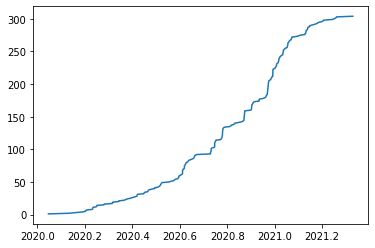

In [36]:
#05-19
plt.plot(s1_nonsyn_dates, s1_running_total)

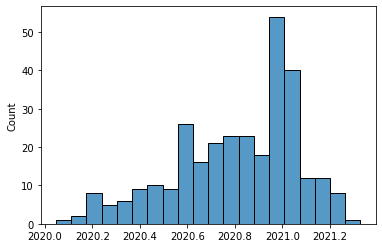

In [45]:
s1_total_plot = []

for d, c in list(zip(s1_nonsyn_dates, s1_nonsyn_counts)):
    for x in range(c):
        s1_total_plot.append(d)

sns.histplot(s1_total_plot, bins=20)

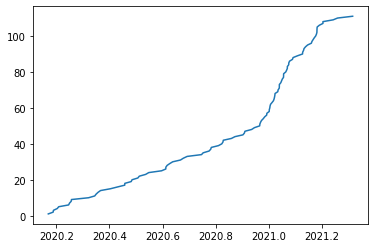

In [44]:
#05-19
plt.plot(s1_syn_dates, s1_syn_running_total)

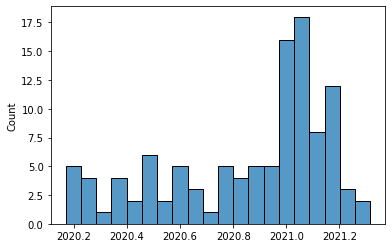

In [46]:
s1_syn_total_plot = []

for d, c in list(zip(s1_syn_dates, s1_syn_counts)):
    for x in range(c):
        s1_syn_total_plot.append(d)

sns.histplot(s1_syn_total_plot, bins=20)

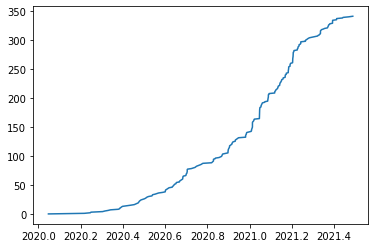

In [30]:
#today
plt.plot(s1_nonsyn_dates, s1_running_total)